In [1]:
import datetime

from src.analysis.plot import Plot
from src.backtest import BackTest
from src.benchmark import Benchmark
from src.factor.roe import RoeFactor
from src.fund_universe import SECURITY_SEDOL
from src.market import Market
from src.portfolio import Portfolio
from src.rebalance import Rebalance
from src.security_symbol import SecurityTicker
from src.analysis.var import Var
from src.analysis.risk_breakdown_to_factor import RiskBreakdownToFactor
from src.analysis.monthly_performance import MonthlyPerformance

In [2]:
start_date = datetime.date(2020, 12, 31)
end_date = datetime.date(2021, 12, 31)
security_universe = SECURITY_SEDOL
rebalance_period = 1
rebalance_interval = "1mo"
# could be EQUAL|MIN_TE|MVO
# rebalance_weight_strategy = "MVO"
Factor = RoeFactor
market = Market(security_universe, start_date, end_date)
benchmark = Benchmark(SecurityTicker("^SPX", "index"), start_date, end_date)
benchmark_performance = benchmark.get_performance()

In [3]:
### equal weight factor
equal_factor = Factor(security_universe, "long")
equal_portfolio = Portfolio(100.0, start_date, end_date)
equal_factor.set_portfolio_at_start(equal_portfolio)

rebalance = Rebalance(
    rebalance_period,
    equal_portfolio,
    equal_factor,
    benchmark,
    rebalance_interval,
    "EQUAL",
)

backtest = BackTest(equal_portfolio, market, rebalance)
backtest.run()

initially buy on 2020-12-31: [('BJN4XN5', 0.05), ('2795393', 0.05), ('2182553', 0.05)]...
rebalance on 2020-12-31: [('BJN4XN5', -0.005), ('2795393', -0.005), ('2182553', -0.005)]...
rebalance on 2021-01-29: [('2516152', -0.053), ('2702337', -0.051), ('2232793', -0.047)]...
rebalance on 2021-02-26: [('B92SR70', -0.047), ('B1F76F9', -0.046), ('BJN4XN5', -0.044)]...
rebalance on 2021-03-31: [('2250687', -0.048), ('2661568', -0.044), ('2536763', -0.004)]...
rebalance on 2021-04-30: [('B7FBFL2', -0.046), ('2002479', -0.045), ('BBGVT40', -0.045)]...
rebalance on 2021-05-28: [('2661568', -0.045), ('2928683', -0.042), ('2502247', -0.006)]...
rebalance on 2021-06-30: [('BYY88Y7', -0.046), ('2795393', -0.045), ('BQ6BPG9', -0.04)]...
rebalance on 2021-07-30: [('2937689', -0.05), ('2886907', -0.047), ('2704407', -0.045)]...
rebalance on 2021-08-31: [('2536763', -0.048), ('2250870', -0.047), ('2914734', -0.045)]...
rebalance on 2021-09-30: [('BS71B31', -0.048), ('BS71BR5', -0.048), ('2093644', -0.0

In [16]:
# var analysis
var = Var(equal_portfolio.value_book.select("date", "value"))
print("Normal Distibution(%):")
display(var.get_normal_distribution_var() * 100)
print("Imperical Value(%):")
display(var.get_imperical_var() * 100)

Normal Distibution(%):


pct,1-day return,5-day return,10-day return,21-day return
f64,f64,f64,f64,f64
90.0,-0.858329,-1.490207,-2.005335,-2.49876
95.0,-1.115014,-1.946085,-2.645923,-3.379046
99.0,-1.596512,-2.801236,-3.847561,-5.030315


Imperical Value(%):


pct,1-day return,5-day return,10-day return,21-day return
f64,f64,f64,f64,f64
90.0,-0.754514,-1.338233,-2.029227,-2.482384
95.0,-1.174693,-2.031205,-2.915636,-3.193573
99.0,-2.123157,-3.186062,-4.417394,-4.148127


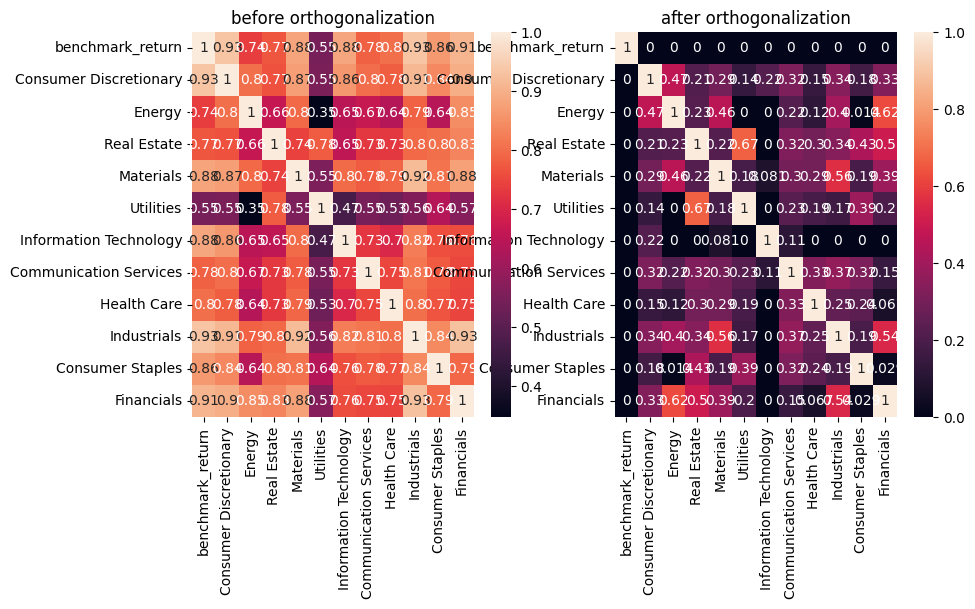

In [5]:
rb = RiskBreakdownToFactor(equal_portfolio, benchmark, end_date)
rb.plot_correlation()

In [6]:
rb.total_risk_breakdown_analysis()

,total_risk,contribution(%),portfolio_weight(%),benchmark_weight(%),active_weight(%)
total_risk,0.109548,100.000000,NaN,NaN,NaN
systematic_risk,0.010161,84.665843,NaN,NaN,NaN
stock_specific_risk,0.001840,15.334157,NaN,NaN,NaN
market_risk,0.008802,73.341323,NaN,NaN,NaN
sector_risk,0.001359,11.324520,NaN,NaN,NaN
Consumer Discretionary,-0.000003,-0.022760,5.0,11.297250,-6.297250
Energy,0.000415,3.454564,5.0,2.522796,2.477204
Real Estate,0.000121,1.012218,0.0,0.168824,-0.168824
Materials,-0.000005,-0.038469,5.0,2.061077,2.938923
Utilities,0.000057,0.475242,0.0,2.426094,-2.426094


In [7]:
rb.tracking_error_breakdown_analysis()

,tracking_error,contribution(%),portfolio_weight(%),benchmark_weight(%),active_weight(%)
tracking_error,0.057626,100.000000,NaN,NaN,NaN
systematic_active_risk,0.001269,38.219387,NaN,NaN,NaN
stock_specific_active_risk,0.002052,61.780613,NaN,NaN,NaN
market_active_risk,0.000011,0.329842,NaN,NaN,NaN
sector_active_risk,0.001258,37.889545,NaN,NaN,NaN
Consumer Discretionary,0.000011,0.326257,5.0,11.297250,-6.297250
Energy,-0.000021,-0.626768,5.0,2.522796,2.477204
Real Estate,-0.000057,-1.725552,0.0,0.168824,-0.168824
Materials,0.000037,1.117097,5.0,2.061077,2.938923
Utilities,0.000168,5.072831,0.0,2.426094,-2.426094


In [8]:
### minimum tracking error factor
min_te_factor = Factor(security_universe, "long")
min_te_portfolio = Portfolio(100.0, start_date, end_date)
min_te_factor.set_portfolio_at_start(min_te_portfolio)

rebalance = Rebalance(
    rebalance_period,
    min_te_portfolio,
    min_te_factor,
    benchmark,
    rebalance_interval,
    "MIN_TE",
)

backtest = BackTest(min_te_portfolio, market, rebalance)
backtest.run()

initially buy on 2020-12-31: [('BJN4XN5', 0.05), ('2795393', 0.05), ('2182553', 0.05)]...
rebalance on 2020-12-31: [('BJN4XN5', -0.039), ('2937689', -0.033), ('2516152', -0.031)]...
rebalance on 2021-01-29: [('2516152', -0.053), ('2702337', -0.051), ('2232793', -0.047)]...
rebalance on 2021-02-26: [('B1F76F9', -0.082), ('B92SR70', -0.059), ('2630643', -0.036)]...
rebalance on 2021-03-31: [('2661568', -0.073), ('2250687', -0.04), ('2704407', -0.008)]...
rebalance on 2021-04-30: [('B7FBFL2', -0.053), ('2702337', -0.044), ('2182553', -0.041)]...
rebalance on 2021-05-28: [('2661568', -0.077), ('2928683', -0.04), ('2250687', -0.007)]...
rebalance on 2021-06-30: [('BYY88Y7', -0.103), ('2795393', -0.046), ('BQ6BPG9', -0.028)]...
rebalance on 2021-07-30: [('2704407', -0.126), ('2702337', -0.07), ('2886907', -0.049)]...
rebalance on 2021-08-31: [('2250870', -0.074), ('B5B1S13', -0.059), ('2914734', -0.048)]...
rebalance on 2021-09-30: [('2093644', -0.086), ('BS71B31', -0.045), ('BS71BR5', -0.04

In [9]:
### MVO factor
mvo_factor = Factor(security_universe, "long")
mvo_portfolio = Portfolio(100.0, start_date, end_date)
mvo_factor.set_portfolio_at_start(mvo_portfolio)

rebalance = Rebalance(
    rebalance_period,
    mvo_portfolio,
    mvo_factor,
    benchmark,
    rebalance_interval,
    "MVO",
)

backtest = BackTest(mvo_portfolio, market, rebalance)
backtest.run()

initially buy on 2020-12-31: [('BJN4XN5', 0.05), ('2795393', 0.05), ('2182553', 0.05)]...
rebalance on 2020-12-31: [('2661568', -0.05), ('2630643', -0.05), ('2702337', -0.05)]...
rebalance on 2021-01-29: [('2433530', -0.054), ('2516152', -0.053), ('2886907', -0.052)]...
rebalance on 2021-02-26: [('2175672', -0.158), ('2536763', -0.156), ('BJN4XN5', -0.114)]...
rebalance on 2021-03-31: [('2378534', -0.104), ('2937689', -0.069), ('2182553', -0.023)]...
rebalance on 2021-04-30: [('2795393', -0.085), ('2928683', -0.047), ('2937689', -0.043)]...
rebalance on 2021-05-28: [('2046251', -0.056), ('2378534', -0.014), ('B65LWX6', -0.004)]...
rebalance on 2021-06-30: [('2795393', -0.202), ('2046251', -0.053), ('2607647', -0.009)]...
rebalance on 2021-07-30: [('B65LWX6', -0.169), ('2046251', -0.037), ('BKVD2N4', 0.004)]...
rebalance on 2021-08-31: [('2536763', -0.252), ('2046251', -0.064), ('BQ6BPG9', -0.024)]...
rebalance on 2021-09-30: [('2898087', -0.055), ('2795393', -0.054), ('BBGVT40', -0.012

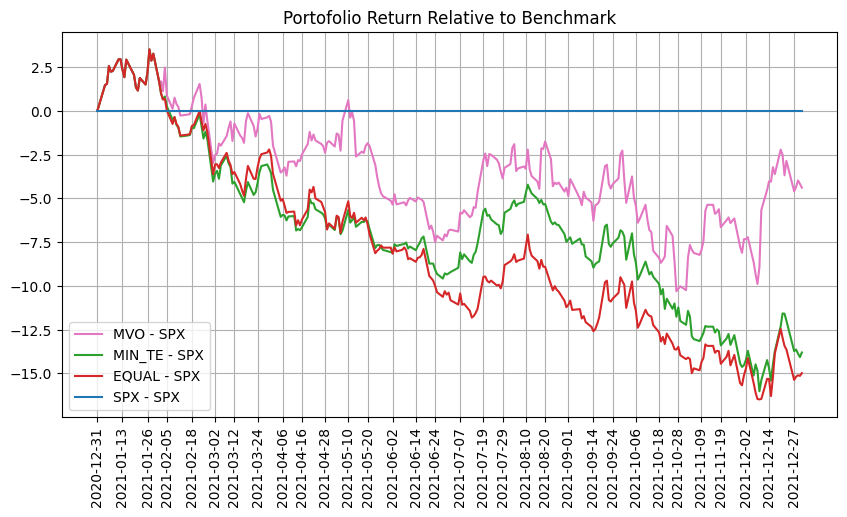

In [10]:
### plot
plot = Plot(
    equal_portfolio,
    min_te_portfolio,
    mvo_portfolio,
    benchmark_performance,
    "SPX",
)
plot.plot_performance()

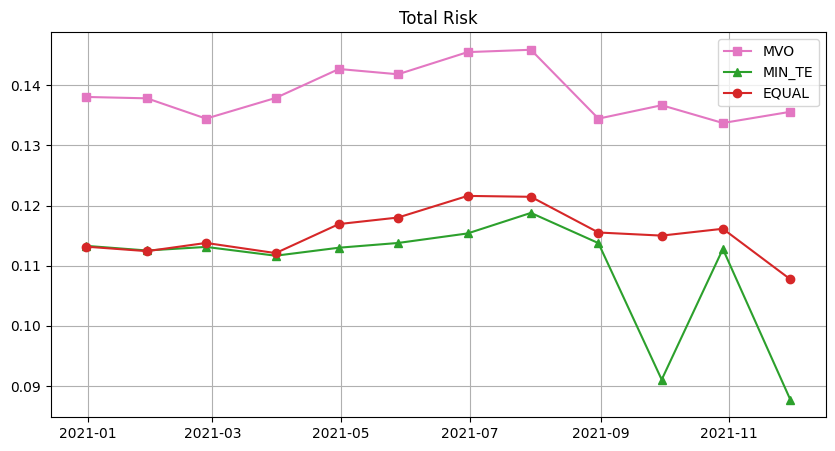

In [11]:
plot.plot_total_risk()

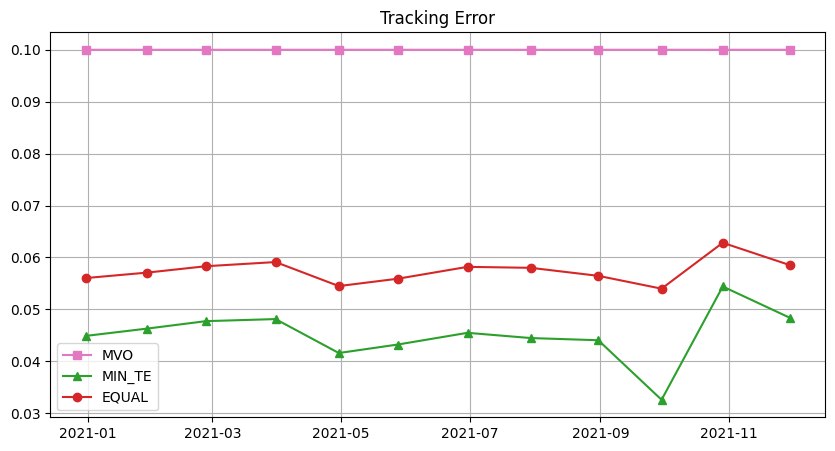

In [12]:
plot.plot_tracking_error()

In [31]:
import polars as pl

stat1 = MonthlyPerformance().get_annualized_stat(
    mvo_portfolio.value_book.select("date", "value"), benchmark_performance
)
stat2 = MonthlyPerformance().get_annualized_stat(
    min_te_portfolio.value_book.select("date", "value"), benchmark_performance
)
stat3 = MonthlyPerformance().get_annualized_stat(
    equal_portfolio.value_book.select("date", "value"), benchmark_performance
)
stat = pl.concat([stat1, stat2, stat3], how="vertical")
pl.concat(
    [
        pl.DataFrame({"label": ["MVO", "MIN_TE", "EQUAL_WEIGHT"]}),
        stat,
    ],
    how="horizontal",
)

label,monthly_averaged_return(annualized),monthly_averaged_volatility(annualized),tracking_error
str,f64,f64,f64
"""MVO""",0.199661,0.117287,0.080907
"""MIN_TE""",0.123412,0.114848,0.067426
"""EQUAL_WEIGHT""",0.107243,0.10107,0.059647
